In this notebook, we explain the details of our `ExpectedAttentionPress`

In [1]:
# matplotlib is not a core dependency of kvpress
!pip install matplotlib --quiet


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
import requests
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

import torch
from transformers import pipeline
from transformers.modeling_attn_mask_utils import AttentionMaskConverter


from kvpress import ExpectedAttentionPress

/mount/home/setup/.cache/pypoetry/virtualenvs/kvpress-PV_RntMw-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Key observation

We start by observing that the hidden states in a transformer model follow a unimodal distribution. This is not true for the very first layers (for instance, layer #0 is simply the distribution of token embeddings) but it is true for the deeper layers (e.g. starting layer #2)

In [3]:
# Load pipeline and data

device = "cuda:0"
ckpt = "meta-llama/Meta-Llama-3.1-8B-Instruct"
# ckpt = "mistralai/Mistral-Nemo-Instruct-2407"
# ckpt = "microsoft/Phi-3.5-mini-instruct"
pipe = pipeline("kv-press-text-generation", model=ckpt, device=device, torch_dtype="auto", model_kwargs={"attn_implementation":"flash_attention_2"})

# Load data
url = "https://en.wikipedia.org/wiki/Nvidia"
content = requests.get(url).content
soup = BeautifulSoup(content, "html.parser")
context = "".join([p.text for p in soup.find_all("p")]) + "\n\n"
tokens = pipe.tokenizer.encode(context, return_tensors="pt").to(device)
n_tokens = tokens.size(1)
print(f"Number of tokens: {n_tokens}")

# Get hidden states
with torch.no_grad():
    outputs = pipe.model(tokens, output_hidden_states=True)

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


Number of tokens: 8914


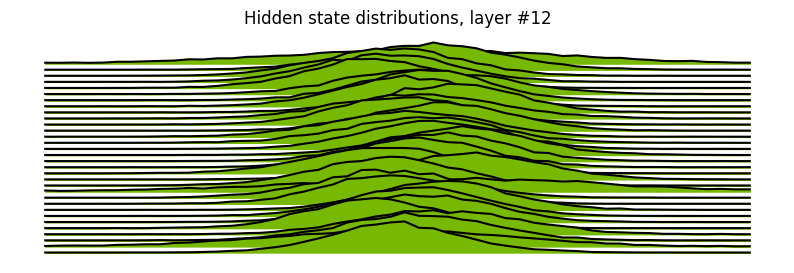

In [4]:
# Display hidden states distribution

layer_idx = 12
n_dims = 32
n_sink = 4 # we don't display the first 4 tokens due to the sink attention phenomenon

H = outputs.hidden_states[layer_idx][0, n_sink:]
H = H.cpu().float().numpy().T
dims = np.random.randint(0, len(H), size=n_dims)
H = H[dims]

x_min = np.percentile(H, 0.1)
x_max = np.percentile(H, 99.9)

plt.figure(figsize=(10, 3))
for i in range(n_dims):
    y, bin_edges = np.histogram(H[i], bins=50, density=True, range=(x_min, x_max))
    x = (bin_edges[1:] + bin_edges[:-1]) / 2

    plt.fill_between(x, y + i, i, zorder=n_dims - i, color="#76B900")
    plt.plot(x, y + i, color="black", zorder=n_dims - i)
    plt.axis("off")
plt.title(f"Hidden state distributions, layer #{layer_idx}");

# Consequence

Let $t_1$, ..., $t_n$ tokens associated with a prompt (pre-filling phase) and $K, V \in \mathbb{R}^{n,d}$ the associated keys and values in a given attention head. We remind that for any query $q$, $$Attention(q, K, V) = \sum_i \frac{e^{q \cdot K_i/\sqrt{d}}}{\sum_j e^{q \cdot K_j/\sqrt{d}}} \cdot V_i$$

For any position $j>n$ we have $q = R_{\theta_j} \cdot W_Q \cdot h$ where $R_{\theta_j}$ is the RoPE rotation matrix at position $j$, $W_Q$ is the query weight matrix, and $h$ is the hidden state after layer norm.

If the distribution of hidden states $h$ is gaussian with $$h \sim \mathcal{N}(μ, Σ)$$ then the distribution of queries at position $j$ is also gaussian: 
$$q_j \sim \mathcal{N}(μ_j, Σ_j)$$
$$μ_j = R_{\theta_j} \cdot W_Q \cdot μ$$
$$ Σ_j = (R_{\theta_j} \cdot W_Q) \cdot Σ \cdot (W_Q \cdot R_{\theta_j})^T$$

This implies that for any key $K_i$ with $i \le n $, we can compute $a_i(j)$, the expected future attention weigth at position $j$  with  $$z_i(j) = E_{q \sim \mathcal{N}(μ_j, Σ_j)}[e^{q \cdot K_i /\sqrt{d}}]  = e^{K_i \cdot \mu_j/\sqrt{d} + K_i \cdot \Sigma_j \cdot K_i/2d}$$ $$a_i(j) = \frac{z_i(j)}{\sum_{i'=1}^n z_{i'}(j)}$$

In our `ExpectedAttentionPress`, we simply replace $R = \frac{1}{n_{f}} \sum_{j=n+1}^{n+n_{f}} R_{\theta_j}$ and use the formula above to compute the expected attention weights. Note that this is slightly abusive (the covariance matrix is not exactly the ones of the future queries) but works well in practice.

In [5]:
# Correlation between expected attention and observed attention

layer_idx = 5
n_train = 5000

print(
    f"Expected attention is computed using the first {n_train} tokens and evaluated on the last {n_tokens - n_train} tokens"
)

# Changing n_future_positions can have a dramatic impact on the correlation because
# most of the attention sparsity matrix is in fact explained by RoPE artifacts
press = ExpectedAttentionPress(use_vnorm=False, n_future_positions=n_tokens - n_train)

keys, values = outputs.past_key_values[layer_idx]
decoder_layer = pipe.model.model.layers[layer_idx]
self_attn = decoder_layer.self_attn
attention_mask = AttentionMaskConverter(is_causal=True).to_causal_4d(1, n_tokens, n_tokens, pipe.torch_dtype, pipe.device)

with torch.no_grad():
    # Compute expected attention (need lot of vRAM to keep all tokens)
    hidden_states = decoder_layer.input_layernorm(outputs.hidden_states[layer_idx])
    parent_cls = self_attn.__class__.__bases__[0] # e.g. LlamaAttention instead of LlamaFlashAttention2
    eager_self_attn = parent_cls(decoder_layer.self_attn.config, layer_idx)
    eager_self_attn.load_state_dict(self_attn.state_dict())
    eager_self_attn.to(device, pipe.torch_dtype)
    position_ids = torch.arange(tokens.size(1), device=device).unsqueeze(0)
    attn_weights = eager_self_attn(hidden_states, position_ids=position_ids, attention_mask=attention_mask, output_attentions=True)[1][0] 

    # Compute scores on the first n_train tokens
    scores = press.scorer.score(
        self_attn, hidden_states[:, :n_train], keys[:, :, :n_train], values[:, :, :n_train], None, None
    )[0]

Expected attention is computed using the first 5000 tokens and evaluated on the last 3914 tokens


The attention layers in this model are transitioning from computing the RoPE embeddings internally through `position_ids` (2D tensor with the indexes of the tokens), to using externally computed `position_embeddings` (Tuple of tensors, containing cos and sin). In v4.46 `position_ids` will be removed and `position_embeddings` will be mandatory.


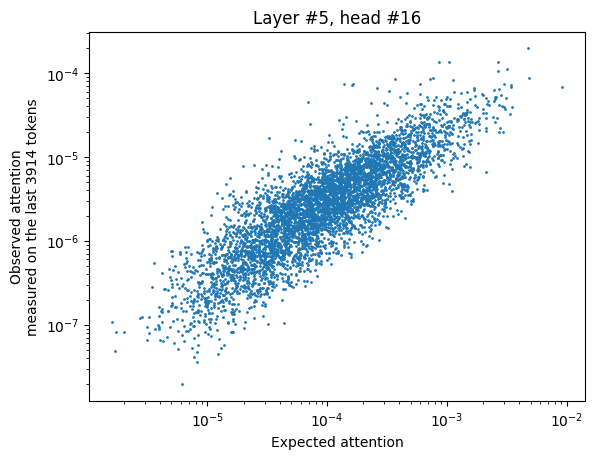

Text(0, 0.5, 'Average attention loss on the last 3914 tokens')

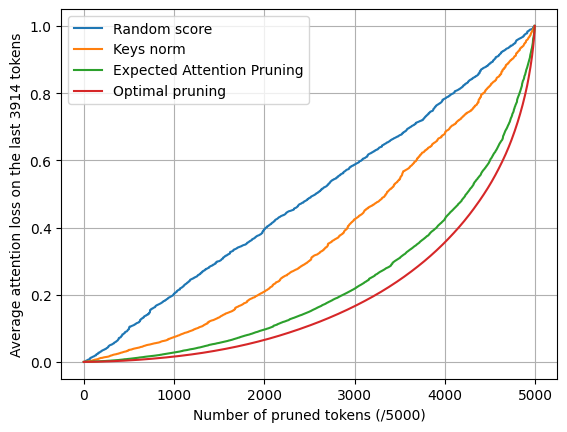

In [6]:
head_idx = 16

# Exclude sink tokens from calculation
kv_head_idx = head_idx // self_attn.num_key_value_groups
observed_attention = attn_weights[head_idx, n_train:, press.scorer.n_sink : n_train].mean(0).float().cpu()
expected_attention = scores[kv_head_idx, press.scorer.n_sink :].float().cpu()

# Display correlation between expected and observed attention
plt.scatter(expected_attention, observed_attention, s=1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Expected attention")
plt.ylabel(f"Observed attention\nmeasured on the last {n_tokens - n_train} tokens")
plt.title(f"Layer #{layer_idx}, head #{head_idx}")
plt.show()

# We can also measure if we pruned the right tokens by measuring the average attention loss on the test tokens
# The optimal pruning curve shows that pruning alone is not enough to achieve high KV cache compression ratio
scale = observed_attention.sum()
knorm = -keys[0, kv_head_idx, press.scorer.n_sink:n_train:].norm(dim=-1).float().cpu()
random = torch.randperm(n_train - press.scorer.n_sink)
for x, label in zip([random, knorm, expected_attention, observed_attention], ["Random score", "Keys norm", "Expected Attention Pruning", "Optimal pruning"]):
    indices = torch.sort(x).indices
    plt.plot(torch.cumsum(observed_attention[indices], dim=0) / scale, label=label)
plt.legend()
plt.grid()
plt.xlabel(f"Number of pruned tokens (/{n_train})")
plt.ylabel(f"Average attention loss on the last {n_tokens - n_train} tokens")

# Adding the value norm

In a transformer, $$Attention(Q,K,V) = softmax(QK^T/\sqrt{d})V = \sum_i a_i V_i $$

Hence, by pruning key-values pairs only based on the expected value of $a_i$, we might remove some pairs with low $a_i$ but high $a_i ||V_i||_2$ . When using `use_vnorm=True` in `ExpectedAttentionPress`, we multiply $score(i)$ by $||V_i||_2$. Note that this effect is small as $a_i$ vary from $1$ to $10^5$ (because of the exponential) while $||V_i||_2$ varies from $1$ to $10^2$ (depending on the models and layers).

In [7]:
vnorm = values[..., press.scorer.n_sink:n_train].norm(dim=-1).float().cpu()
print(scores.max() / scores.min())
print(vnorm.max() / vnorm.min())

tensor(8704., device='cuda:0', dtype=torch.bfloat16)
tensor(48.9765)
